Author: Roberto Ceraolo - roberto.ceraolo@studbocconi.it

In [1]:
import numpy as np
from sklearn.datasets.samples_generator import make_circles
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
import networkx as nx
import seaborn as sns
import pandas as pd
from sklearn import cluster, datasets, mixture
from sklearn.datasets import make_moons, make_biclusters, make_classification

sns.set()
import warnings
warnings.filterwarnings('ignore')


# Intro

Nowadays, spectral clustering is a quite popular modern clustering algorithms. It is simple to implement, can be solved efficiently by standard linear algebra software, and very often outperforms traditional clustering algorithms such as the k-means algorithm. In this notebook we will implement it in three different ways and scenarios, but all grounded on solid theoretical basis.
1. In the first one we will begin by building a graph from a small dataset, then we will apply the unnormalized spectral clustering algorithm from scratch
2. In the second case, we consider a d-regular graph (which has some peculiar features) and we compute its normalized laplacian
3. In the last one we will apply the procedure suggested by [Ng, Jordan, Weiss](#cell3). So we'll build the affinity matrix through Gaussian affinity, then use a normalized graph laplacian to custer the points through spectral clustering

# Spectral clustering from scratch

**Unnormalized spectral clustering  - Luxburg**

In this first section we will implement spectral clustering from scratch on a very simple "toy" dataset. Datapoints are clearly divided into 3 clusters. We will apply the procedure as described in the paper from [Von Luxburg](#cell3). In this case we will make use of the unnormalized laplacian.
The procedure will be as follows:
1. First of all, we will need to create a graph from the dataset. To do so, we need to decide a similarity measure and build the adjacency matrix. There are three main ways to do so, and in this example we will implement one of them (ε neighborhood)
2. Then, we will compute the degree and unnormalized laplacian matrices
3. Through the eigenvalues of the graph laplacian we will infer the right number of clusters k (eigengap heuristic)
4. Through k eigenvectors of the laplacian we will cluster the datapoints (clustering the rows of the matrix made up by those vectors as columns)

Of course, sklearn has a function to quickly implement spectral clustering, but we are building it from scratch to appreciate the whole procedure and make use of linear algebra, to fully understand the theoretical framework, following the procedures suggested by the [papers](#cell3). 



## From dataset to graph

Firstly, we will show the steps to go from the dataset to the graph. Let's consider a certain simple dataset, such as the following.

Text(0, 0.5, 'Height')

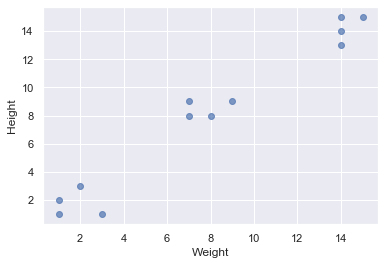

In [2]:
n=12 #num of datapoints
np.random.seed(42)
X = np.array([
    [1, 2], [3, 1], [1, 1],
    [2, 3], [7, 9], [8, 8],
    [9, 9], [7, 8], [14, 13],
    [14, 14], [15, 15], [14, 15]
])

plt.scatter(X[:,0], X[:,1], alpha=0.7, edgecolors='b')
plt.xlabel('Weight')
plt.ylabel('Height')

Since spectral clustering is applied to graphs, we need to move from a dataset to a graph. Then we will consider its Laplacian matrix and finally we will have a look at its eigenvalues.
First of all, we need to choose a metric and build a similarity matrix. In this case, we chose the euclidean distance between datapoints. Then, we will need to build the adjacency matrix. To do so, there are three common methods.

1. The ε neighborhood graph: connecting all points whose pairwise distances are smaller than ε the graph is unweighted
2. _K_-nearest neighbors graph: connecting vertex vi with vertex vj if vj is among the k-nearest neighbors of vi. It can be made undirected by connecting vi with vj if vi is a neighbor of vj or the opposite. Otherwise, through mutual k-nearest neighobrs we two vertices must be mutual neighbors to be connected
3. Complete graph: connecting all edges with postiive similarity with each other, weighting all edges depending on the measure of similarity.


### ε neighborhood graph

For the time being, let's consider the ε neighborhood graph. We set a threshold ε for which two datapoints are connected if and only if the euclidean distance between them is under a certain level.

Barely any theoretical results are known to guide us in the task of choosing the value of the connectivity parameter ε. As a rule of thumb, it is good practice to choose ε such that the resulting graph is safely connected. To do so, we should choose ε as the length of the longest edge in a minimal spanning tree of the fully connected graph on the data points. However, such heuristic will choose ε very large in presence of outliers in data.

In [3]:
#Fully connected graph
G = nx.complete_graph(n, create_using=None)
W = pairwise_distances(X, metric="euclidean")
G.add_weighted_edges_from((u,v,W[u,v]) for u,v in G.edges())
mst = nx.minimum_spanning_tree(G) #Kruskal’s algorithm
l=list(mst.edges.data("weight", default=1))
weights = list(zip(*l))[2]
eps=max(weights)
print(eps)

7.0710678118654755


Now that we have the parameter ε, we can compute the adjacency matrix.

In [4]:
vec = np.vectorize(lambda x: 1 if x <= eps else 0)
W = np.vectorize(vec)(W)
np.fill_diagonal(W, 0)
print(W)

[[0 1 1 1 0 0 0 0 0 0 0 0]
 [1 0 1 1 0 0 0 0 0 0 0 0]
 [1 1 0 1 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 1 1 0 0 0 0]
 [0 0 0 0 1 0 1 1 0 0 0 0]
 [0 0 0 0 1 1 0 1 1 1 0 0]
 [0 0 0 1 1 1 1 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 1 1 1]
 [0 0 0 0 0 0 1 0 1 0 1 1]
 [0 0 0 0 0 0 0 0 1 1 0 1]
 [0 0 0 0 0 0 0 0 1 1 1 0]]


We extract the list of edges from the adjacency matrix in order to plot the graph

In [5]:
edges=[]
a = np.nonzero(W)[0]
b = np.nonzero(W)[1]
for i in range(len(a)):
    if (b[i], a[i]) not in edges:
        edges.append((a[i],b[i]))
edges

[(0, 1),
 (0, 2),
 (0, 3),
 (1, 2),
 (1, 3),
 (2, 3),
 (3, 7),
 (4, 5),
 (4, 6),
 (4, 7),
 (5, 6),
 (5, 7),
 (6, 7),
 (6, 8),
 (6, 9),
 (8, 9),
 (8, 10),
 (8, 11),
 (9, 10),
 (9, 11),
 (10, 11)]

Finally, we plot a possible visual configuration of the graph given the edges just found.

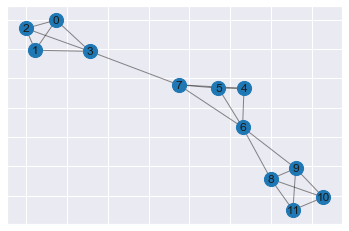

In [6]:
gr = nx.Graph()
vert = np.arange(n)
gr.add_nodes_from(vert)
gr.add_edges_from(edges)
def draw_graph(G):
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=200)
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    
draw_graph(gr)

## From Graph to Clusters

A very useful matrix for analysing and clustering graphs is the Laplacian matrix. It is defined as: $$L=D-A$$ where D is the degree matrix and A the adjacency one.
To compute the degree matrix, we sum over one of the axis the values of the adjancency matrix. Then, we build a matrix with those values on the diagonals.

It can be shown that he Laplacian marix has the following properties:
1. For every vector $f \in R^{n}$ we have $$f'Lf = \dfrac{1}{2} \sum_{i,j=1}^{n}w_{ij}(f_{i}-f_{j})^{2} \$$
2. L is symmetric and positive semi-definite.
3. The smallest eigenvalue of L is 0, the corresponding eigenvector is the constant one vector
4. L has n non-negative, real-valued eigenvalues 0 = λ1 ≤ λ2 ≤ . . . ≤ λn .

In [7]:
#degree matrix
D = np.diag(np.sum(W, axis=1))
print('degree matrix:')
print(D)
# laplacian matrix
L = D - W
print('laplacian matrix:')
print(L)

degree matrix:
[[3 0 0 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 0 0 0 0 0 0 0 0]
 [0 0 0 4 0 0 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 0 0 4 0 0 0]
 [0 0 0 0 0 0 0 0 0 4 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 0 0 3]]
laplacian matrix:
[[ 3 -1 -1 -1  0  0  0  0  0  0  0  0]
 [-1  3 -1 -1  0  0  0  0  0  0  0  0]
 [-1 -1  3 -1  0  0  0  0  0  0  0  0]
 [-1 -1 -1  4  0  0  0 -1  0  0  0  0]
 [ 0  0  0  0  3 -1 -1 -1  0  0  0  0]
 [ 0  0  0  0 -1  3 -1 -1  0  0  0  0]
 [ 0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
 [ 0  0  0 -1 -1 -1 -1  4  0  0  0  0]
 [ 0  0  0  0  0  0 -1  0  4 -1 -1 -1]
 [ 0  0  0  0  0  0 -1  0 -1  4 -1 -1]
 [ 0  0  0  0  0  0  0  0 -1 -1  3 -1]
 [ 0  0  0  0  0  0  0  0 -1 -1 -1  3]]


### Choosing the number of clusters

It can be also shown that the multiplicity k of the eigenvalue 0 of the Laplacian, is the number of connected compontents of the graph. In this example we have only 1 connected component, so we will have only one eigenvalue equals exactly to 0. Anyway, we could infer something from the other eigenvalues having values near 0.

In model based clustering settings, log-likelihood is used to understand the right number of clusters. But we, for the purpose of these notes, make no assumptions on the underlying data.
In settings where no or few assumptions on the underlying model are made, there are several measures can be used, such as within-cluster and between-cluster similiarities.
Anyway, one tool which is particularly designed for spectral clustering is the **eigengap heuristic**.

The goal is to choose k such that $λ_{1}$ .. $λ_{k}$ are very small and $λ_{k+1}$ is relatively large. One justification for this procedure is based on perturbation theory. We observe that in the special case of k disconnected clusters, the eigenvalue 0 has multiplicity k, and then there is a gap to the (k + 1)th eigenvalue of $λ_{k+1}$ > 0. For more, see Bolla (1991), Mohar (1997) and Chung (1997).

Text(0.5, 1.0, 'Eigenvalues')

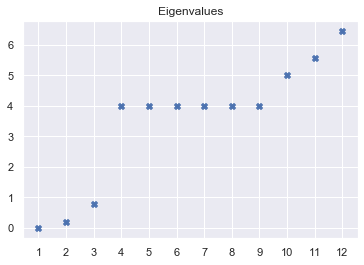

In [8]:
e, v = np.linalg.eig(L)
e.sort()
plt.scatter(np.arange(len(e)), e, marker="X")#1 clusters
plt.xticks(np.arange(n), [str(i) for i in range(1, n+1)])
plt.title("Eigenvalues")

The eigengap euristic works well when clusters in the data are well pronounced, as in this case. In presence of noise or overlapping clusters it quicly loses effectiveness ([see 3 for more on this](#cell2)).
We now proceed with 3 clusters.

### K-means step

Finally, we need to cluster the datapoints.

We have the matrix $v$ composed of the eigenvectors of the unnormalized graph laplacian matrix. We consider the first k vectors, build a matrix with them as columns. Then, we cluster the rows of such matrix through K-means clustering.





In [9]:
#We want just the first k eigenvectors
k=3
u=v[:,:k]#this contains the eigenvectors as columns
print(u)


[[-0.28867513 -0.40645416 -0.15286721]
 [-0.28867513 -0.40645416 -0.15286721]
 [-0.28867513 -0.40645416 -0.15286721]
 [-0.28867513 -0.32071598 -0.03128591]
 [-0.28867513  0.08988919  0.47992219]
 [-0.28867513  0.08988919  0.47992219]
 [-0.28867513  0.15666599  0.21980251]
 [-0.28867513  0.00415101  0.35834089]
 [-0.28867513  0.28317657 -0.19699514]
 [-0.28867513  0.28317657 -0.19699514]
 [-0.28867513  0.31656497 -0.32705498]
 [-0.28867513  0.31656497 -0.32705498]]


Now, point i is in cluster j if row i of the matrix is in cluster j

In [10]:
#We now cluster the rows of the above matrix through k-means 
kmeans = KMeans(n_clusters=k, random_state=30).fit(u)
labels = kmeans.labels_
labels



array([1, 1, 1, 1, 0, 0, 0, 0, 2, 2, 2, 2], dtype=int32)

Text(0, 0.5, 'Height')

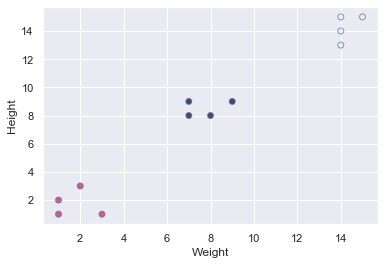

In [11]:
plt.scatter(X[:,0], X[:,1], alpha=0.7, c = labels, edgecolors='b')
plt.xlabel('Weight')
plt.ylabel('Height')

# _d_-regular case

We now consider a stochastic undirected d-regular graphs and apply a similar procedure - this time with the normalized laplacian. Let's start by computing the adjancency matrix.

Adjacency matrix
[[0 1 0 1 1 0 0 0 0 1]
 [1 0 0 0 0 1 0 1 1 0]
 [0 0 0 1 1 0 1 0 1 0]
 [1 0 1 0 0 0 0 1 0 1]
 [1 0 1 0 0 1 0 0 0 1]
 [0 1 0 0 1 0 0 1 1 0]
 [0 0 1 0 0 0 0 1 1 1]
 [0 1 0 1 0 1 1 0 0 0]
 [0 1 1 0 0 1 1 0 0 0]
 [1 0 0 1 1 0 1 0 0 0]]


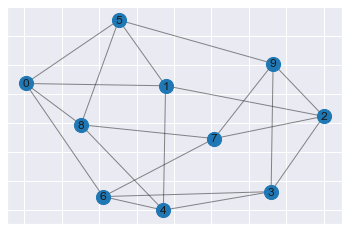

In [12]:
d=4
n=10
G=nx.random_regular_graph(d, n, seed=32)
draw_graph(G)
A = nx.adjacency_matrix(G)
A=A.todense()
print("Adjacency matrix")
print(A)

For d-regular graphs, there is a convenient way to compute the normalized laplacian matrix. In d-regular graphs, the normalized laplacian is: $$L = I-\dfrac{1}{d}A$$ where A is the adjacency matrix. It is a special case of the formula $L=D-A$.
If you used the k-nearest neighbor graph or the ε-neighborhood graph for the adjacency, then the laplacian is sparse.

Moreover, it has some useful properties.
It can be proved that, given a d-regular graph G, and let λ1...λn be the eigenvalues of the normalized laplacian in nondecreasing order, we have
1. λ1 = 0, λn ≤ 2
2. λk = 0 iff G has at least k connected components
3. λn = 2 iff at least one of the connected components of G is bipartite


In [13]:
L = np.identity(n) - 1/d * A
print("Normalized Laplacian Matrix")
print(L)

Normalized Laplacian Matrix
[[ 1.   -0.25  0.   -0.25 -0.25  0.    0.    0.    0.   -0.25]
 [-0.25  1.    0.    0.    0.   -0.25  0.   -0.25 -0.25  0.  ]
 [ 0.    0.    1.   -0.25 -0.25  0.   -0.25  0.   -0.25  0.  ]
 [-0.25  0.   -0.25  1.    0.    0.    0.   -0.25  0.   -0.25]
 [-0.25  0.   -0.25  0.    1.   -0.25  0.    0.    0.   -0.25]
 [ 0.   -0.25  0.    0.   -0.25  1.    0.   -0.25 -0.25  0.  ]
 [ 0.    0.   -0.25  0.    0.    0.    1.   -0.25 -0.25 -0.25]
 [ 0.   -0.25  0.   -0.25  0.   -0.25 -0.25  1.    0.    0.  ]
 [ 0.   -0.25 -0.25  0.    0.   -0.25 -0.25  0.    1.    0.  ]
 [-0.25  0.    0.   -0.25 -0.25  0.   -0.25  0.    0.    1.  ]]


We now compute the eigenvalues and eigenvectors of the normalized Laplacian.

In [14]:
e, v = np.linalg.eig(L)
# eigenvalues
print('eigenvalues:')
print(e)
# eigenvectors
print('eigenvectors:')
print(v)

eigenvalues:
[-4.44089210e-16  1.72767906e+00  1.57569391e+00  1.44985066e+00
  1.25000000e+00  5.22320939e-01  6.74306091e-01  8.00149343e-01
  1.00000000e+00  1.00000000e+00]
eigenvectors:
[[-3.16227766e-01 -2.53016505e-01 -1.18303883e-01 -5.55344509e-01
  -2.58198890e-01  3.54046243e-01 -3.90731184e-01 -4.71845625e-02
  -4.08248290e-01 -1.73827787e-02]
 [-3.16227766e-01  2.53016505e-01 -1.18303883e-01  5.55344509e-01
  -2.58198890e-01 -3.54046243e-01 -3.90731184e-01  4.71845625e-02
  -4.08248290e-01 -1.73827787e-02]
 [-3.16227766e-01 -3.88755822e-01 -2.72427300e-01  2.35220241e-01
  -2.58198890e-01  6.46982520e-02  5.09035067e-01 -1.98379648e-01
  -1.09583910e-15 -4.99546553e-01]
 [-3.16227766e-01  4.53454074e-01  9.02522556e-16 -3.68405931e-02
   3.87298335e-01  3.24057570e-01 -1.06692686e-15  4.33599890e-01
   1.38298387e-16 -4.99546553e-01]
 [-3.16227766e-01  3.54046243e-01  3.90731184e-01  4.71845625e-02
  -2.58198890e-01  2.53016505e-01 -1.18303883e-01 -5.55344509e-01
   4.0824

<a id='cell2'></a>
As expected, the lowest eigenvalue is 0 and the highest one is less than than 2. We could also expect the strict inequality since the graph is not bipartite.

Text(0.5, 1.0, 'Eigenvalues')

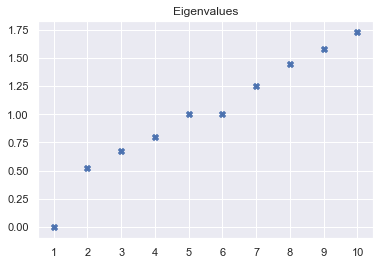

In [15]:
e.sort()
plt.scatter(np.arange(n), e, marker="X")#1 clusters
plt.xticks(np.arange(n), [str(i) for i in range(1, n+1)])
plt.title("Eigenvalues")

The eigengap heuristic in this case is not very useful. The reason is that there are no pronounced clusters. There just seems to be a slight gap between the second and the third eigenvalue.

# Ng Jordan Weiss - Normalized Laplacian


In this section we will implement spectral clustering from scratch on a couple of common datasets. Datapoints are clearly (to the human eye) divided into 2 clusters. We will apply the procedure as described in the paper from Ng, Jordan, Weiss. In this case we will make use of a peculiar normalized laplacian.
The procedure will be as follows:
1. First of all, we will build an affinity matrix through the Gaussian affinity, hence: $$A_{i,j}=exp(-||s_{i}-s{j}||^{2}/2\sigma^{2})\;\;\; if\;\; i \neq j, A_{ii}=0$$ 
2. Then, we will compute the degree matrix and then the normalized laplacian in this way: $$L=D^{-\frac{1}{2}}AD^{-\frac{1}{2}}$$
3. We take the first k (k=2 in this example) eigenvectors of L and we stack them in columns in a matrix X. Then we normalize the matrix by
$$Y_{ij} = \frac{X_{ij}}{\left( \sum\limits_{j=1}^n X_{ij}^2 \right)^{\frac{1}{2}}}$$
4. Considering each row of Y as a point, we cluster them into k clusters throuh K-means
5. We assign point $s_{i}$ to cluster $j$ iff row $i$ of matrix Y was assigned to cluster $j$


Firstly, let's plot the dataset.

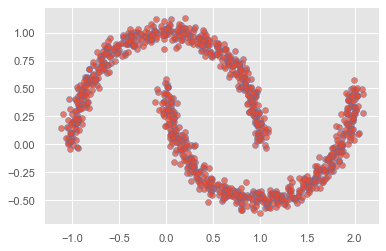

In [16]:
plt.style.use('ggplot')
X, y = make_moons(n_samples=1000, noise=.05)
plt.scatter(X.T[0], X.T[1],alpha=0.7,  cmap="rainbow", edgecolors='b')

From the following representation we can check if the data is separable with the value that we chose for $\sigma ^{2}$, the parameter for the Gaussian kernel affiinity. In case it is not separable, we reduce the value of the parameter.

In [17]:
def compute_spectral(X, sigmasq):
    sigmasq=sigmasq 
    A = np.exp(-1./(2 * sigmasq) * pairwise_distances(X, metric='sqeuclidean'))
    D = np.diag(A.sum(axis=1)**-0.5)
    L = np.dot(D,A)
    L = np.dot(L,D)  

    e, v = np.linalg.eig(L) #eigenvectors
    v = np.real(v)
    Y = v[:, :2]

    Y /= np.linalg.norm(Y, axis=1).reshape(-1, 1) #normalization
    Y_x = Y.T[0]
    Y_y = Y.T[1]
    return Y_x, Y_y, Y


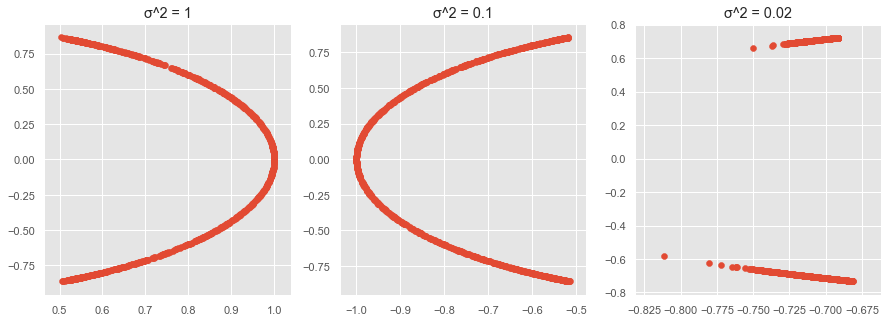

In [18]:

f = plt.figure(figsize=(15,5))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)
axs = [ax1, ax2, ax3]
plts = [1,2,3]
sigmas = [1, 0.1, 0.02]
for i in range(3):
    ax = axs[i]
    ax.set_title("\N{GREEK SMALL LETTER SIGMA}^2 = " + str(sigmas[i]))
    x, y, _ = compute_spectral(X, sigmas[i])
    plts[i]=ax.scatter(x, y)

Now that we chose a value for the parameter, we can actually run the algorithm. I condensed it in 2 cells in order to achieve a cleaner code. For comparison, we also plot the clustered data using directly k-means

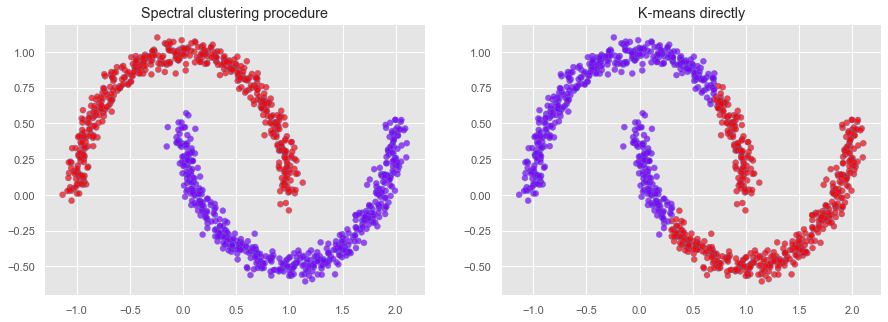

In [19]:
def compare(X):
    f = plt.figure(figsize=(15,5))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)

    sigmasq = 0.02
    Y = compute_spectral(X, sigmasq)[2]
    kmeans = KMeans(n_clusters=2)
    clusters = kmeans.fit_predict(Y)
    ax1.set_title('Spectral clustering procedure')
    plt1 = ax1.scatter(X.T[0], X.T[1], c=clusters, cmap='rainbow', alpha=0.7, edgecolors='b')


    km = KMeans(init='k-means++', n_clusters=2)
    km_clustering = km.fit(X)
    ax2.set_title('K-means directly')
    plt2 = ax2.scatter(X[:,0], X[:,1], c=km_clustering.labels_, cmap='rainbow', alpha=0.7, edgecolors='b')

X, y = make_moons(n_samples=1000, noise=.05)
compare(X)

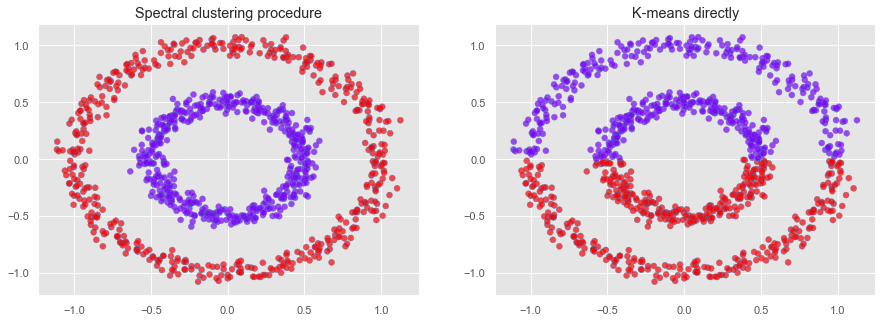

In [20]:
X, clusters = make_circles(n_samples=1000, noise=.05, factor=.5, random_state=0)
compare(X)

Spectral Clustering is useful when the structure of the individual clusters is highly non-convex or more generally when a measure of the center and spread of the cluster is not a suitable description of the complete cluster. For instance, as we saw, when clusters are nested circles on the 2D plane.

<a id='cell3'></a>
# References

1. Ng, A.Y., Jordan, M.I. and Weiss, Y., 2002. On spectral clustering: Analysis and an algorithm.

2. Bach, F.R. and Jordan, M.I., 2004. Learning spectral clustering.

3. U. Von Luxburg, 2007, A tutorial on spectral slustering.

4. Trevisan, 2017, Lecture Notes on Graph Partitioning, Expanders and Spectral Methods
